In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle -q

In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c el-hackathon-2025

  0% 0.00/41.1M [00:00<?, ?B/s]
100% 41.1M/41.1M [00:00<00:00, 1.28GB/s]


In [ ]:
!mkdir -p ./data/el-hackathon-2025
!unzip el-hackathon-2025.zip -d ./data/el-hackathon-2025
!ls ./data/el-hackathon-2025

Archive:  el-hackathon-2025.zip
  inflating: ./data/el-hackathon-2025/elucidata_ai_challenge_data.h5  
elucidata_ai_challenge_data.h5


In [ ]:
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from scipy.stats import spearmanr

import os

from torchvision import models, transforms
from torchvision.transforms import v2
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR

from torch.utils.data import TensorDataset, DataLoader, Dataset

from collections import defaultdict

import albumentations as A

from PIL import Image

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## 1. FILE UPLOADING

In [ ]:
filename = '/content/data/el-hackathon-2025/elucidata_ai_challenge_data.h5'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class CONFIG:
  patch_size = 224
  img_size = 224
  num_cell_types = 35

  NUM_EPOCHS = 40
  LEARNING_RATE = 1e-4
  WEIGHT_DECAY = 1e-4
  BATCH_SIZE = 64

In [ ]:
def explore_h5_group(group, indent=0):
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Group):
            print('  ' * indent + f"{key}/ (Group)")
            explore_h5_group(item, indent + 1)
        elif isinstance(item, h5py.Dataset):
            print('  ' * indent + f"{key} (Dataset) shape: {item.shape}, dtype: {item.dtype}")
        else:
            print('  ' * indent + f"{key} (Unknown type: {type(item)})")

with h5py.File(filename, 'r') as f:
    print("Top-level keys:", list(f.keys()))
    for key in f.keys():
        print(f"\nExploring '{key}':")
        explore_h5_group(f[key], indent=1)

Top-level keys: ['images', 'spots']

Exploring 'images':
  Test/ (Group)
    S_7 (Dataset) shape: (1983, 2000, 3), dtype: float32
  Train/ (Group)
    S_1 (Dataset) shape: (2000, 1974, 3), dtype: float32
    S_2 (Dataset) shape: (2000, 1988, 3), dtype: float32
    S_3 (Dataset) shape: (2000, 1966, 3), dtype: float32
    S_4 (Dataset) shape: (2000, 1979, 3), dtype: float32
    S_5 (Dataset) shape: (1985, 2000, 3), dtype: float32
    S_6 (Dataset) shape: (2000, 1930, 3), dtype: float32

Exploring 'spots':
  Test/ (Group)
    S_7 (Dataset) shape: (2088,), dtype: [('x', '<i8'), ('y', '<i8'), ('Test_Set', '<i8')]
  Train/ (Group)
    S_1 (Dataset) shape: (2197,), dtype: [('x', '<i8'), ('y', '<i8'), ('C1', '<f8'), ('C2', '<f8'), ('C3', '<f8'), ('C4', '<f8'), ('C5', '<f8'), ('C6', '<f8'), ('C7', '<f8'), ('C8', '<f8'), ('C9', '<f8'), ('C10', '<f8'), ('C11', '<f8'), ('C12', '<f8'), ('C13', '<f8'), ('C14', '<f8'), ('C15', '<f8'), ('C16', '<f8'), ('C17', '<f8'), ('C18', '<f8'), ('C19', '<f8'), ('

## 2. SOME EDA

### 2.1. SPOT OVERLAYS

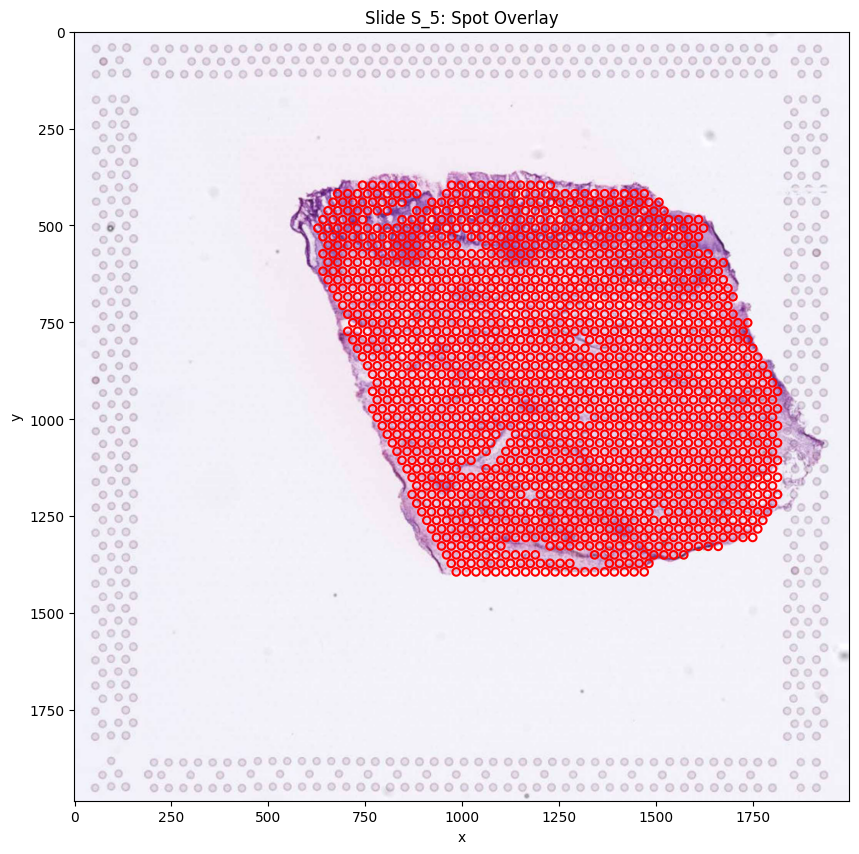

In [ ]:
import matplotlib.pyplot as plt

slide_id = 'S_5'

with h5py.File(filename, 'r') as f:
    img = f["images"]["Train"][slide_id][:]
    spots = f["spots"]["Train"][slide_id][:]
    x = spots["x"]
    y = spots["y"]

plt.figure(figsize=(10, 10))
plt.imshow(img.astype("float32") / img.max())
plt.scatter(x, y, s=30, edgecolor="red", facecolor="none", linewidth=1.5)
plt.title(f"Slide {slide_id}: Spot Overlay")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### 2.2. DOMINANT CELL TYPES PER SPOTS

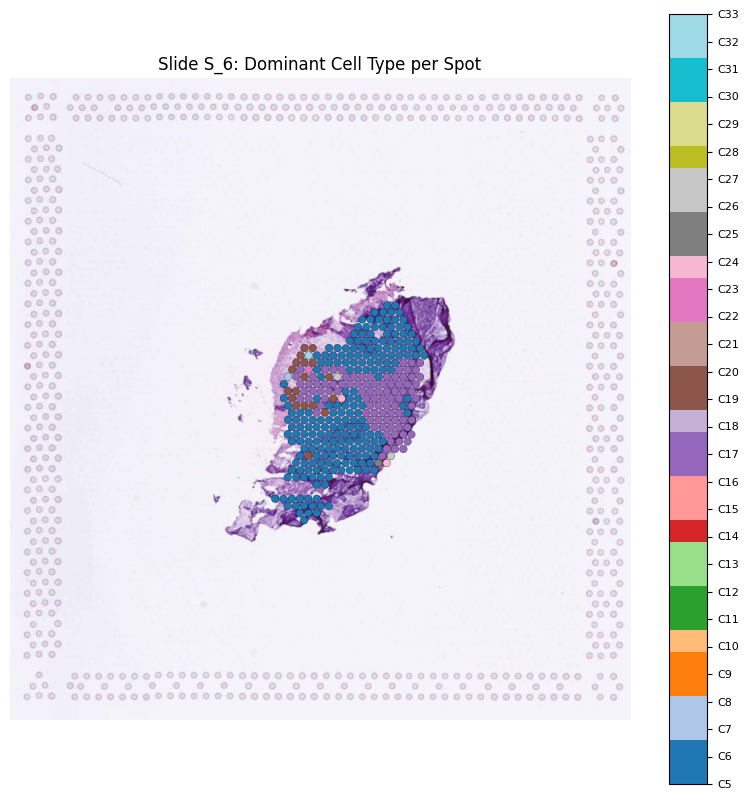

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

slide_id = 'S_6'
cell_types = [f"C{i}" for i in range(1,36)]


with h5py.File(filename, 'r') as f:
    img = f['images']['Train'][slide_id][:]
    spots = f['spots']['Train'][slide_id][:]
    x = spots['x']
    y = spots['y']
    all_abund = np.vstack([spots[c] for c in cell_types]).T

max_idx = np.argmax(all_abund, axis=1)

cmap=plt.get_cmap("tab20", 35)

plt.figure(figsize=(10, 10))
plt.imshow(img.astype('float32')/img.max())
sc = plt.scatter(x, y, c=max_idx, cmap=cmap, s=30, edgecolor='k', linewidth=0.2)
cb = plt.colorbar(sc, ticks=np.arange(35))
cb.set_ticklabels(cell_types)
cb.ax.tick_params(labelsize=8)
plt.title(f"Slide {slide_id}: Dominant Cell Type per Spot")
plt.axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

slide_id = 'S_5'
cell_types = [f'C{i}' for i in range(1, 36)]

with h5py.File(filename, 'r') as f:
    spots = f['spots']['Train'][slide_id][:]
    # Build a DataFrame for easier analysis
    df = pd.DataFrame({ct: spots[ct] for ct in cell_types})

# Display summary statistics
display(df.describe())

# # Plot histograms for all cell types
# fig, axes = plt.subplots(7, 5, figsize=(18, 18))
# axes = axes.flatten()
# for i, ct in enumerate(cell_types):
#     axes[i].hist(df[ct], bins=30, color='skyblue', edgecolor='k')
#     axes[i].set_title(ct)
#     axes[i].set_yscale('log')  # Use log scale for clarity if many zeros
# plt.tight_layout()
# plt.show()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35
count,1677.000000,1677.000000,1677.000000,1.677000e+03,1677.000000,1.677000e+03,1677.000000,1677.000000,1.677000e+03,1.677000e+03,...,1677.000000,1.677000e+03,1.677000e+03,1.677000e+03,1.677000e+03,1677.000000,1677.000000,1.677000e+03,1.677000e+03,1677.000000
mean,0.177059,0.158723,0.118722,6.600923e-02,0.031681,1.511096e-01,0.030622,0.045922,3.880639e-01,4.942092e-02,...,0.112755,1.977206e-01,2.343134e-02,2.666816e-02,3.047917e-01,0.095392,0.079107,4.872141e-02,2.524444e-02,0.043664
std,1.078666,0.204027,0.561316,5.484388e-01,0.133534,4.986063e-01,0.047321,0.151086,1.154045e+00,1.899313e-01,...,0.313132,6.736727e-01,5.465372e-02,8.727256e-02,4.865053e-01,0.140931,0.116859,1.273888e-01,8.324104e-02,0.070524
min,0.000070,0.001574,0.000313,1.634036e-07,0.000002,7.562380e-08,0.000075,0.000002,2.279151e-07,3.314041e-08,...,0.000001,7.140767e-08,4.070647e-07,7.280677e-07,4.033238e-08,0.000743,0.000517,4.529015e-07,5.850457e-07,0.000128
25%,0.010408,0.032723,0.010509,1.051407e-05,0.000113,2.164569e-05,0.003548,0.000449,2.361223e-04,1.705499e-04,...,0.000799,2.954092e-05,5.092416e-04,2.615369e-04,3.425876e-04,0.016568,0.012301,2.505176e-04,3.153087e-04,0.005031
50%,0.037651,0.085546,0.030356,1.221910e-04,0.000676,7.211821e-04,0.012651,0.004177,1.000583e-02,2.262946e-03,...,0.010404,7.388387e-04,5.009393e-03,2.819539e-03,7.273339e-02,0.046748,0.036603,3.762417e-03,2.573192e-03,0.016926
75%,0.103396,0.195750,0.077399,6.360504e-03,0.010003,3.076793e-02,0.037165,0.028428,1.412737e-01,1.755487e-02,...,0.086601,4.776140e-02,2.237175e-02,1.507782e-02,3.822469e-01,0.112197,0.094610,3.455015e-02,1.401269e-02,0.048899
max,29.454552,1.493361,13.434405,9.771889e+00,2.622473,6.475006e+00,0.447323,2.452402,1.019514e+01,2.670770e+00,...,5.047303,7.950480e+00,1.122224e+00,1.760810e+00,3.301860e+00,1.549890,1.201457,1.881064e+00,1.460682e+00,0.683063


## 3. PREPROCESSING THE DATA TO FEED TO THE MODEL

In [ ]:
import h5py
import numpy as np

train_slides = [f'S_{i}' for i in range(1, 7)]
patch_size = CONFIG.patch_size
half_size = patch_size // 2

all_patches = {}
all_labels = {}
all_coords = {}

with h5py.File(filename, 'r') as f:
    for slide_id in tqdm(train_slides, desc="Slides"):
        img = f['images']['Train'][slide_id][:] # 1985x2000x3 -> height, width, rgb
        spots = f['spots']['Train'][slide_id][:] # 1677, 1677 number of spots in S_5
        x = spots['x']
        y = spots['y']

        cell_types = [f'C{i}' for i in range(1, 36)]
        labels = np.stack([spots[ct] for ct in cell_types], axis=1)  # shape: (num_spots, 35) 35 labels for each spot

        patches = []
        for xi, yi in zip(x, y):
            x_min = max(xi - half_size, 0)
            x_max = min(xi + half_size, img.shape[1])
            y_min = max(yi - half_size, 0)
            y_max = min(yi + half_size, img.shape[0])
            patch = img[y_min:y_max, x_min:x_max, :] # crop img for all 3 color channels
            if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                patch = np.pad(
                    patch,
                    ((0, patch_size - patch.shape[0]), (0, patch_size - patch.shape[1]), (0, 0)),
                    mode='constant'
                )
            patches.append(patch)

        all_patches[slide_id] = np.stack(patches)  # (num_spots, patch_size, patch_size, 3)
        all_labels[slide_id] = labels              # (num_spots, 35)
        all_coords[slide_id] = np.stack([x, y], axis=1)  # (num_spots, 2)

# Example: check shapes for one slide
for slide_id in train_slides:
    print(f"{slide_id}: patches {all_patches[slide_id].shape}, labels {all_labels[slide_id].shape}, coords {all_coords[slide_id].shape}")


# for each slides, we get (num_patches, patch_size, patch_size, 3)

Slides: 100%|██████████| 6/6 [00:01<00:00,  3.51it/s]

S_1: patches (2197, 224, 224, 3), labels (2197, 35), coords (2197, 2)
S_2: patches (2270, 224, 224, 3), labels (2270, 35), coords (2270, 2)
S_3: patches (690, 224, 224, 3), labels (690, 35), coords (690, 2)
S_4: patches (1187, 224, 224, 3), labels (1187, 35), coords (1187, 2)
S_5: patches (1677, 224, 224, 3), labels (1677, 35), coords (1677, 2)
S_6: patches (328, 224, 224, 3), labels (328, 35), coords (328, 2)


In [ ]:
if 'cell_type_names' not in globals(): # Check if cell_type_names is defined
    num_cell_types = list(all_labels.values())[0].shape[1] # Get number of cell types from first slide
    cell_type_names = [f'C{i}' for i in range(1, num_cell_types + 1)]

In [ ]:
summary_stats_list = []

for slide_id, labels in all_labels.items():
    for i, cell_type_name in enumerate(cell_type_names):
        cell_abundances = labels[:, i]
        mean_abundance = np.mean(cell_abundances)
        median_abundance = np.median(cell_abundances)
        std_abundance = np.std(cell_abundances)
        # Percentage of spots where the cell type is present (abundance > a small epsilon, e.g., 0.001 or just >0)
        presence_threshold = 1e-5 # Adjust if your abundances are very small
        percent_present = np.mean(cell_abundances > presence_threshold) * 100

        summary_stats_list.append({
            'slide_id': slide_id,
            'cell_type': cell_type_name,
            'mean_abundance': mean_abundance,
            'median_abundance': median_abundance,
            'std_abundance': std_abundance,
            'percent_present': percent_present,
            'num_spots_in_slide': labels.shape[0]
        })

summary_df = pd.DataFrame(summary_stats_list)
print("--- Summary Statistics (First few rows) ---")
print(summary_df.head())
print("\n--- Summary Statistics for S_5 ---")
print(summary_df[summary_df['slide_id'] == 'S_5'].head())

--- Summary Statistics (First few rows) ---
  slide_id cell_type  mean_abundance  median_abundance  std_abundance  \
0      S_1        C1        0.121815          0.029458       0.396826   
1      S_1        C2        0.089254          0.054229       0.113059   
2      S_1        C3        0.093587          0.037990       0.228135   
3      S_1        C4        0.015726          0.002307       0.033866   
4      S_1        C5        1.699786          0.542953       2.343158   

   percent_present  num_spots_in_slide  
0       100.000000                2197  
1       100.000000                2197  
2       100.000000                2197  
3        99.772417                2197  
4       100.000000                2197  

--- Summary Statistics for S_5 ---
    slide_id cell_type  mean_abundance  median_abundance  std_abundance  \
140      S_5        C1        0.177059          0.037651       1.078344   
141      S_5        C2        0.158723          0.085546       0.203966   
142      S

## 4. DATA AUGMENTATIONS AND DATASET PREPARING FOR TORCH

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

train_transforms = A.Compose([

    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),

    A.Affine(
        scale=(0.9, 1.1),
        translate_percent=(-0.1, 0.1),
        rotate=(-25, 25),
        shear=(-7, 7),
        p=0.9
    ),
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
        A.GaussNoise(var_limit=(5.0, 30.0)),
      ], p=0.7),
    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
      ], p=0.7),


    A.CLAHE(clip_limit=4.0, p=0.7),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),


    A.Normalize(mean=norm_mean, std=norm_std),
    ToTensorV2()
])

valid_transforms = A.Compose([
    # A.Resize(CONFIG.img_size, CONFIG.img_size),
    A.Normalize(mean=norm_mean, std=norm_std),
    ToTensorV2()
])

from scipy.stats import rankdata

class PatchDataset(Dataset):
    def __init__(self, patches, original_targets=None, transform=None, rank_transform_targets=False, num_classes=35):
        self.patches = patches
        self.original_targets = original_targets # Store for metric
        self.transform = transform
        self.rank_transform_targets = rank_transform_targets
        self.num_classes = num_classes

        if original_targets is not None:
            if self.rank_transform_targets:
                self.targets_for_loss = np.empty_like(self.original_targets, dtype=np.float32)
                for i in range(self.original_targets.shape[0]):
                    ranks = rankdata(self.original_targets[i, :], method='average')
                    # Normalize ranks to [0, 1]
                    self.targets_for_loss[i, :] = (ranks - 1.0) / (self.num_classes - 1.0)
            else: # original sqrt transform
                self.targets_for_loss = np.sqrt(np.maximum(self.original_targets, 0))
        else:
            self.targets_for_loss = None

    def __len__(self): return len(self.patches)

    def __getitem__(self, idx):
        img = self.patches[idx]
        if img.dtype != np.uint8: img = (img * 255).astype(np.uint8) if img.max() <= 1.0 else img.astype(np.uint8)
        if self.transform: augmented = self.transform(image=img); img_tensor = augmented["image"]
        else: fallback_aug = A.Compose([A.Normalize(mean=norm_mean, std=norm_std), ToTensorV2()]); img_tensor = fallback_aug(image=img)["image"]

        if self.targets_for_loss is None: return img_tensor

        y_loss = torch.tensor(self.targets_for_loss[idx], dtype=torch.float32)
        # y_orig_for_metric = torch.tensor(self.original_targets[idx], dtype=torch.float32)
        return img_tensor, y_loss

# 3) to_loader with transforms
def to_loader(X, y=None, shuffle=None, transform=None, batch_size=32, num_workers=2, rank_transform_targets=False, num_classes=35):
    ds = PatchDataset(X, y, transform=transform, rank_transform_targets=rank_transform_targets, num_classes=num_classes)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle,
                      num_workers=num_workers, pin_memory=True)


<ipython-input-18-aaadfb64e091>:24: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5.0, 30.0)),


## 5. SOME UTILITIES

In [ ]:
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# def spearman_corr(preds, target):
#     corrs = [spearmanr(preds[i], target[i]).correlation for i in range(len(preds))]
#     return np.nanmean(corrs)


def spearman_corr(preds_spot_major, target_spot_major):
    # preds_spot_major: (num_spots, 35)
    # target_spot_major: (num_spots, 35)
    num_spots = preds_spot_major.shape[0]
    spot_corrs = []
    for i in range(num_spots):
        # Calculate Spearman for the 35 cell types for this single spot
        correlation, p_value = spearmanr(preds_spot_major[i, :], target_spot_major[i, :])
        if not np.isnan(correlation): # Handle cases where correlation might be NaN
            spot_corrs.append(correlation)

    if not spot_corrs: # If all correlations were NaN
        return 0.0
    return np.mean(spot_corrs)


mixup_transform = v2.MixUp(num_classes=CONFIG.num_cell_types) # alpha for MixUp
cutmix_transform = v2.CutMix(num_classes=CONFIG.num_cell_types) # alpha for CutMix


def train_one_epoch(model, optimizer, loader, device, criterion, scheduler=None):
    model.train()
    running_loss = 0.0
    all_preds, all_targs = [], []
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        if random.random() < 0.3:
          xb, yb = cutmix_transform(xb, yb)

        pred   = model(xb)
        loss   = criterion(pred, yb)
        loss.backward()
        optimizer.step(); optimizer.zero_grad()
        if scheduler: scheduler.step()
        running_loss += loss.item() * xb.size(0)
        all_preds.append(pred.detach().cpu().numpy())
        all_targs.append(yb.cpu().numpy())

    train_preds = np.vstack(all_preds)
    train_targs = np.vstack(all_targs)
    train_score = spearman_corr(train_preds, train_targs)

    return running_loss / len(loader.dataset), train_score

def valid_one_epoch(model, loader, device, criterion):
    model.eval()
    running_loss = 0.0
    all_preds, all_targs = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred   = model(xb)
            loss   = criterion(pred, yb)
            running_loss += loss.item() * xb.size(0)
            all_preds.append(pred.cpu().numpy())
            all_targs.append(yb.cpu().numpy())
    val_loss = running_loss / len(loader.dataset)
    preds    = np.vstack(all_preds)
    targs    = np.vstack(all_targs)
    val_score = spearman_corr(preds, targs)
    return val_loss, val_score, preds, targs

def run_training(train_loader, valid_loader,
                 model, optimizer, criterion, scheduler,
                 device, num_epochs, seed=42):
    set_seed(seed)
    history = defaultdict(list)
    best_score = -np.inf
    best_state = None
    best_preds = None
    epochs_no_improve = 0
    patience = 10

    for epoch in range(1, num_epochs+1):

        train_loss, train_score = train_one_epoch(model, optimizer, train_loader,
                                     device, criterion, scheduler)
        history['train_loss'].append(train_loss)
        history['train_score'].append(train_score)

        val_loss, val_score, val_preds, val_targs = valid_one_epoch(model, valid_loader,
                                                  device, criterion)
        history['val_loss'].append(val_loss)
        history['val_score'].append(val_score)

        current_lr = optimizer.param_groups[-1]['lr']

        print(
            f"Epoch {epoch}/{num_epochs}  "
            f"LR={current_lr:.6f}  "
            f"Train L={train_loss:.4f}  Train Spearman={train_score:.4f}  "
            f"Val L={val_loss:.4f}    Val Spearman={val_score:.4f}"
        )
        if val_score > best_score:
                best_score = val_score
                best_state = model.state_dict()
                best_preds = val_preds
                epochs_no_improve = 0
                print(f"🚀 New best Val Spearman (Metric): {best_score:.4f}")
        else:
                epochs_no_improve += 1
                print(f"😥 No improvement for {epochs_no_improve} epochs. Best: {best_score:.4f}")

        if epochs_no_improve >= patience:
            print(f"Stopping early after {epoch} epochs due to no improvement for {patience} epochs.")
            break

        # val_preds_orig = np.clip(val_preds, 0, None) ** 2
        # val_targs_orig = np.clip(val_targs, 0, None) ** 2
        # val_score_orig_scale = spearman_corr(val_preds_orig, val_targs_orig)
        val_score_orig_scale = spearman_corr(val_preds, val_targs)
        print(f"Val Spearman (original scale): {val_score_orig_scale:.4f}")

    # load best
    if best_state is not None:
        model.load_state_dict(best_state)
    print(f"Best CV Spearman: {best_score:.4f}")
    return model, history, best_preds

## 6. MODEL TRAINING SETUP

In [ ]:
torch.cuda.empty_cache()

In [ ]:
%%time


slide_ids = list(all_patches.keys())  # ['S_1',…,'S_6']
cv_scores = []
oof_preds = {}
oof_targets = {}
oof_indices = {}
best_fold_models = {}


SAVE_PATH = "best_models"
os.makedirs(SAVE_PATH, exist_ok=True)

for val_slide in slide_ids:
    set_seed(42)

    # 2) leave-one-slide-out split
    train_slides = [s for s in slide_ids if s != val_slide]
    X_train = np.concatenate([all_patches[s] for s in train_slides], axis=0)
    y_train = np.concatenate([all_labels[s] for s in train_slides], axis=0)
    X_val   = all_patches[val_slide]
    y_val   = all_labels[val_slide]

    if X_train.shape == (0,) or X_val.shape == (0,):
        print(f"Skipping slide {val_slide} due to empty data")
        continue


    # y_train = np.sqrt(y_train)
    # y_val = np.sqrt(y_val)

    train_loader = to_loader(X_train, y_train, shuffle=True, transform=train_transforms, batch_size=CONFIG.BATCH_SIZE, rank_transform_targets=True)
    val_loader   = to_loader(X_val,   y_val,   shuffle=False, transform=valid_transforms, batch_size=CONFIG.BATCH_SIZE*2, rank_transform_targets=True)

    weights = models.EfficientNet_V2_M_Weights
    model = models.efficientnet_v2_m(weights=weights)

    in_features = model.classifier[-1].in_features
    new_classifier_layers = list(model.classifier.children())[:-1]
    new_classifier_layers.extend([
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features, y_train.shape[1]),
        nn.Sigmoid()
    ])
    model.classifier = nn.Sequential(*new_classifier_layers)

    # weights = models.Swin_S_Weights.IMAGENET1K_V1
    # model = models.swin_s(weights=weights)

    # in_features = model.head.in_features

    # model.head = torch.nn.Sequential(
    #     torch.nn.Linear(in_features, y_train.shape[1]),
    #     torch.nn.Sigmoid(),
    # )

    #-------------------------------------------------------------------#


    # model = models.convnext_tiny(pretrained=True)
    # original_classifier = model.classifier

    # in_features = original_classifier[-1].in_features
    # new_classifier_layers = list(original_classifier.children())[:-1]


    # new_classifier_layers.extend([
    #     nn.Dropout(p=0.2, inplace=True),
    #     nn.Linear(in_features, y_train.shape[1]),
    #     nn.Sigmoid()
    # ])

    # model.classifier = nn.Sequential(*new_classifier_layers)

    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-3)
    criterion = nn.L1Loss()

    scheduler = CosineAnnealingLR(
        optimizer,
        T_max=CONFIG.NUM_EPOCHS,
        eta_min=1e-7,
    )

    # scheduler = OneCycleLR(
    #     optimizer,
    #     max_lr=8e-4,
    #     steps_per_epoch=len(train_loader),
    #     epochs=CONFIG.NUM_EPOCHS,
    #     pct_start=0.2, # Adjust pct_start if needed
    #     anneal_strategy='cos',
    # )


    print(f"\n--- Training fold {val_slide} ---")
    model, history, best_fold_preds = run_training(
        train_loader, val_loader, model, optimizer, criterion, scheduler,
        device, num_epochs=CONFIG.NUM_EPOCHS, seed=42
    )

    # best_fold_preds_original_scale = np.clip(best_fold_preds, 0, None) ** 2
    # y_val_original_scale = np.clip(y_val, 0, None) ** 2

    best_fold_preds_original_scale = best_fold_preds
    y_val_original_scale = y_val

    oof_preds[val_slide] = best_fold_preds
    oof_targets[val_slide] = y_val
    oof_indices[val_slide] = np.arange(len(y_val))

    fold_score = spearman_corr(best_fold_preds_original_scale, y_val_original_scale)
    print(f"Fold {val_slide} ▶️ Best Spearman = {fold_score:.4f}\n")
    cv_scores.append(fold_score)
    best_fold_models.setdefault(val_slide, model.state_dict()) # Save the best model state
    print("Best model for fold saved.")

mean_cv = np.mean(cv_scores)
std_cv  = np.std(cv_scores)


all_oof_preds = np.vstack([oof_preds[slide] for slide in slide_ids])
all_oof_targets = np.vstack([oof_targets[slide] for slide in slide_ids])

# all_oof_preds = np.clip(all_oof_preds, 0, None) ** 2
# all_oof_targets = np.clip(all_oof_targets, 0, None) ** 2
overall_cv_score = spearman_corr(all_oof_preds, all_oof_targets)


print("\n==== CV RESULTS ====")
print(f"Mean fold CV: {mean_cv:.4f} ± {std_cv:.4f}")
print(f"Overall CV score (from all OOF): {overall_cv_score:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_M_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:00<00:00, 234MB/s]



--- Training fold S_1 ---
Epoch 1/40  LR=0.000006  Train L=0.2032  Train Spearman=0.3505  Val L=0.2371    Val Spearman=0.3615
🚀 New best Val Spearman (Metric): 0.3615
Val Spearman (original scale): 0.3615
Epoch 2/40  LR=0.000001  Train L=0.1621  Train Spearman=0.6350  Val L=0.2285    Val Spearman=0.3901
🚀 New best Val Spearman (Metric): 0.3901
Val Spearman (original scale): 0.3901
Epoch 3/40  LR=0.000002  Train L=0.1511  Train Spearman=0.6604  Val L=0.2254    Val Spearman=0.4163
🚀 New best Val Spearman (Metric): 0.4163
Val Spearman (original scale): 0.4163
Epoch 4/40  LR=0.000008  Train L=0.1459  Train Spearman=0.6720  Val L=0.2273    Val Spearman=0.4072
😥 No improvement for 1 epochs. Best: 0.4163
Val Spearman (original scale): 0.4072
Epoch 5/40  LR=0.000010  Train L=0.1437  Train Spearman=0.6809  Val L=0.2267    Val Spearman=0.4196
🚀 New best Val Spearman (Metric): 0.4196
Val Spearman (original scale): 0.4196
Epoch 6/40  LR=0.000004  Train L=0.1369  Train Spearman=0.7117  Val L=0.226

In [ ]:
# CONVNEXT RESULTS
# 40 epoch, 5e-7 t_min, 1e-3 weight decay
# Mean fold CV: 0.6385 ± 0.0407
# Overall CV score (from all OOF): 0.6500

## 7. INFERENCE SETUP

In [ ]:
import h5py
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

# Parameters
filename   = '/content/data/el-hackathon-2025/elucidata_ai_challenge_data.h5'
slide_id   = 'S_7'
patch_size = CONFIG.patch_size
half_size  = patch_size // 2
num_cell_types = 35

# 1) Extract test patches and coords
with h5py.File(filename, 'r') as f:
    img   = f['images']['Test'][slide_id][:]
    spots = f['spots']['Test'][slide_id][:]
    x, y  = spots['x'], spots['y']

test_patches = []
test_coords  = []
for xi, yi in zip(x, y):
    x_min = max(xi - half_size, 0)
    x_max = min(xi + half_size, img.shape[1])
    y_min = max(yi - half_size, 0)
    y_max = min(yi + half_size, img.shape[0])
    patch = img[y_min:y_max, x_min:x_max, :]
    if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
        patch = np.pad(
            patch,
            ((0, patch_size - patch.shape[0]),
             (0, patch_size - patch.shape[1]),
             (0, 0)),
            mode='constant'
        )
    test_patches.append(patch)
    test_coords.append((xi, yi))

test_patches = np.stack(test_patches, axis=0)  # (n_spots, 64, 64, 3)
test_coords  = np.array(test_coords)           # (n_spots, 2)


test_ds = PatchDataset(test_patches, transform=valid_transforms, rank_transform_targets=True, num_classes=35)
test_loader = DataLoader(test_ds, batch_size=CONFIG.BATCH_SIZE*2, shuffle=False,
                         num_workers=2, pin_memory=True)

In [ ]:
all_fold_test_preds = []

for fold, saved_state in best_fold_models.items():
    print(f"Loading best model for fold {fold}...")

    # model = models.convnext_tiny(pretrained=False)
    # original_classifier = model.classifier
    # in_features = original_classifier[-1].in_features
    # new_classifier_layers = list(original_classifier.children())[:-1]
    # new_classifier_layers.extend([
    #     nn.Dropout(p=0.2, inplace=True),
    #     nn.Linear(in_features, y_train.shape[1]),
    #     nn.Sigmoid()
    #     ])
    # model.classifier = nn.Sequential(*new_classifier_layers)

    model = models.efficientnet_v2_m(weights=None)

    in_features = model.classifier[-1].in_features
    new_classifier_layers = list(model.classifier.children())[:-1]
    new_classifier_layers.extend([
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features, y_train.shape[1]),
        nn.Sigmoid()
    ])
    model.classifier = nn.Sequential(*new_classifier_layers)


    # model = models.resnet18(pretrained=False)
    # model.fc = torch.nn.Sequential(
    #     torch.nn.Linear(model.fc.in_features, num_cell_types)
    # )


    model.load_state_dict(saved_state)
    model.to(device)
    model.eval()
    fold_preds = []
    with torch.no_grad():
        for xb in test_loader:
            xb = xb.to(device)
            pred_orig = model(xb)

            xb_hflip = torch.flip(xb, dims=[-1])
            pred_hflip = model(xb_hflip)

            xb_vflip = torch.flip(xb, dims=[-2])
            pred_vflip = model(xb_vflip)

            xb_hvflip = torch.flip(xb, dims=[-1, -2])
            pred_hvflip = model(xb_hvflip)

            batch_preds_avg = (pred_orig + pred_hflip + pred_vflip + pred_hvflip) / 4

            fold_preds.append(batch_preds_avg.cpu().numpy())
    fold_preds_np = np.vstack(fold_preds)
    all_fold_test_preds.append(fold_preds_np)

if all_fold_test_preds:
    final_preds_sqrt_scale = np.mean(all_fold_test_preds, axis=0)
    final_preds = final_preds_sqrt_scale
    # final_preds = final_preds_sqrt_scale ** 2
    # final_preds = np.clip(final_preds_sqrt_scale, 0, None) ** 2
    print("Ensembled TTA predictions generated.")
else:
    print("Warning: No best models were saved for ensembling")
    final_preds = None


Loading best model for fold S_1...
Loading best model for fold S_2...
Loading best model for fold S_3...
Loading best model for fold S_4...
Loading best model for fold S_5...
Loading best model for fold S_6...
Ensembled TTA predictions generated.


In [ ]:
with h5py.File(filename, "r") as f:
    test_spots = f["spots/Test"]
    test_spot_table = pd.DataFrame(np.array(test_spots['S_7']))  # Example slide S_7

import pandas as pd

# Load and display (x,y) spot locations and cell type annotation table for Train slides
with h5py.File(filename, "r") as f:
    train_spots = f["spots/Train"]

    # Dictionary to store DataFrames for each slide
    train_spot_tables = {}

    for slide_name in train_spots.keys():
        # Load dataset as NumPy structured array
        spot_array = np.array(train_spots[slide_name])

        # Convert to DataFrame
        df = pd.DataFrame(spot_array)

        # Store in dictionary
        train_spot_tables[slide_name] = df

In [ ]:
cell_type_columns = train_spot_tables['S_1'].columns[2:].values
indices = test_spot_table.index.values
predicted_labels = pd.DataFrame(final_preds, columns=cell_type_columns, index=indices)
predicted_labels.head()

In [ ]:
submission_df  = predicted_labels.copy()

submission_df.insert(0, 'ID', test_spot_table.index)
submission_df.to_csv("submission.csv", index=False)
print("Submission file 'submission.csv' created!")

submission_df.head()